## **<div style="text-align: center;"> ETHNICS INEQUALITIES WITHIN WIKISPEEDIA </div>**

**IMPORT THE LIBRARY**

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
from tqdm import tqdm 
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
from unidecode import unidecode
from matplotlib.colors import Normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
import networkx as nx


from scipy import stats
from statsmodels.stats import diagnostic
from sklearn.cluster import KMeans
import math
import spacy, nltk, gensim, sklearn
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats
from statsmodels.stats import diagnostic
import networkx as nx
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.decomposition import PCA



**OPEN THE DATA**

In [2]:
#Open and import the dataset 
dataFolder = 'Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
#linksDf.reset_index()

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#paths_finishedDf

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

people_skin_color = pd.read_csv(dataFolder + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color.columns = ['Category', 'People', 'Skin Color']
people_skin_color['People'] = people_skin_color['People'].map(lambda x : unquote(x, 'utf-8'))
people_skin_color.reset_index()

#We change how some names are wrote so that there are similar to the names in in paths_finishedDf and paths_unfininishedDf 
people_skin_color['People'] = people_skin_color['People'].replace('Adolf Hitler', 'Adolf_Hitler')
people_skin_color['People'] = people_skin_color['People'].replace('John F. Kennedy', 'John_F._Kennedy')
people_skin_color['People'] = people_skin_color['People'].str.replace(' ', '_')
#people_skin_color.loc[(people_skin_color['People'] == 'Jesus') & 
#                      (people_skin_color['Skin Color'] == 'Arab-Persian-Bizantin'), 'Skin Color'] = 'White'


categories_details = categoriesDf["categories"].str.split(".", expand=True)
#keep only the main category
threshold = 100
categories = pd.concat([categories_details[1], categories_details[2], categories_details[3]],axis = 0)
categories = pd.DataFrame(categories)
categories = categories.rename(columns = {0 : 'Main_Categories'})

categories_distribution=categories['Main_Categories'].value_counts()
 
categories_distribution['People'] = categories_distribution['People'] + categories_distribution['Peoples']
categories_distribution = categories_distribution.drop('Peoples')
categories_distribution = categories_distribution[categories_distribution > threshold]
categories_distribution = categories_distribution.sort_values()

### **1. Distribution of articles in each categories**


The dataset 'categories' contains main categories and then sub-categories. We will focus on main categories.

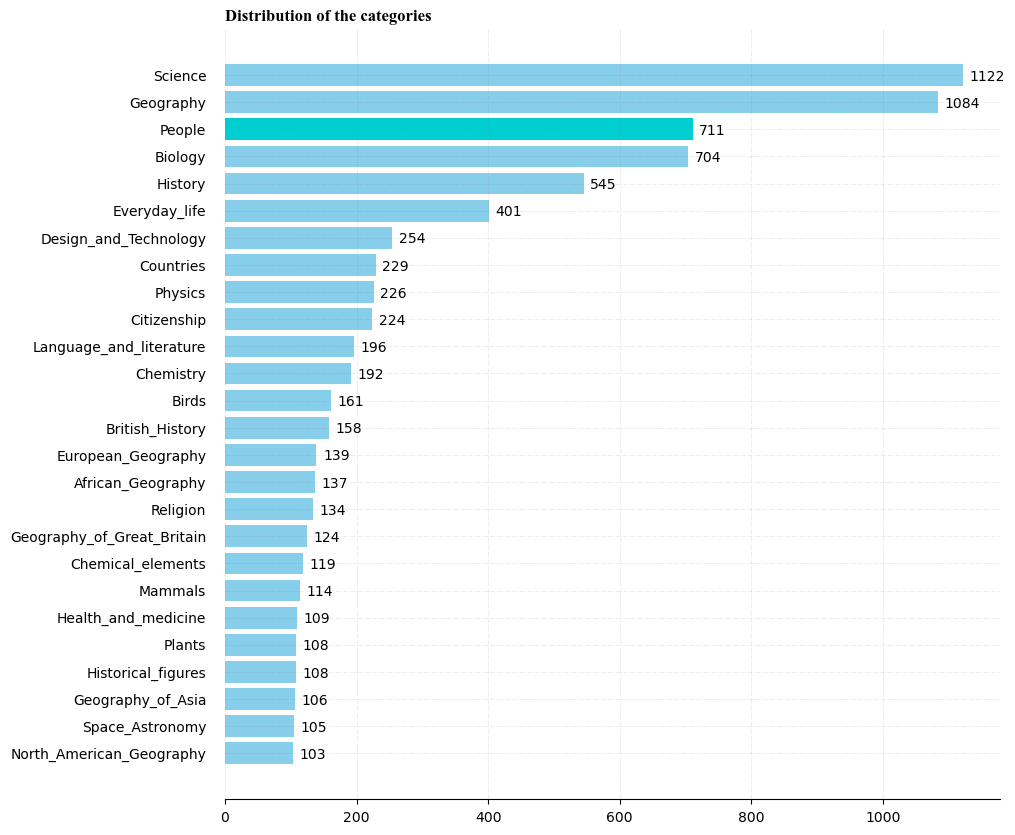

In [3]:
fig, ax = plt.subplots(figsize =(10, 10))
colors = ['skyblue' if cat != 'People' else 'darkturquoise' for cat in categories_distribution.index]
ax.barh(categories_distribution.index, categories_distribution, color=colors)
 
# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove y Tick
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
 

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() +10, i.get_y()+0.20, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

ax.set_title('Distribution of the categories', loc='left', fontweight= 'bold', fontname='Times New Roman')

plt.show()


People is the third category containing the bigger amount of articles (around 700 articles). We will know focus on this category and used our new dataset 'people_with_skin_color.tsv'

### **2. The ethnics distribution whitin people articles**

To continue, we will focus on the ethnics distribution whithin the people articles. Ethnicity is a quality or a fact of belonging to a population group or subgroup made up of people who share a common cultural background or descent. Here we class the people on physical ethnicity which means we class them to have large groups of people with common racial, national, tribal, religious, linguistic, or cultural origin or background.  
We assign the ethnics groups of each person contained in the People category based on their physical ethnicity appartenance. To make it easier for us, we decide to focus on the following main ethnic groups : 
- White 
- Asian
- Black  
- Arab-Persian-Byzantin
- Hispanic 
- American Indian
- Australian aboriginal

In [4]:
people_color =  pd.concat([people_skin_color, people_skin_color['Category'].str.split(".", expand=True)], axis=1)
people_color = people_color.drop(columns = ['Category', 0, 1])
people_color = people_color.rename(columns = {1 : 'Categories'})

unique_color=people_color['Skin Color']

people_color_dist=people_color['Skin Color'].value_counts()
people_color_dist


Skin Color
White                    608
Asian                     37
Black                     32
Arab-Persian-Bizantin     23
Hispanic                   7
American Indian            1
Australian Aboriginal      1
Name: count, dtype: int64

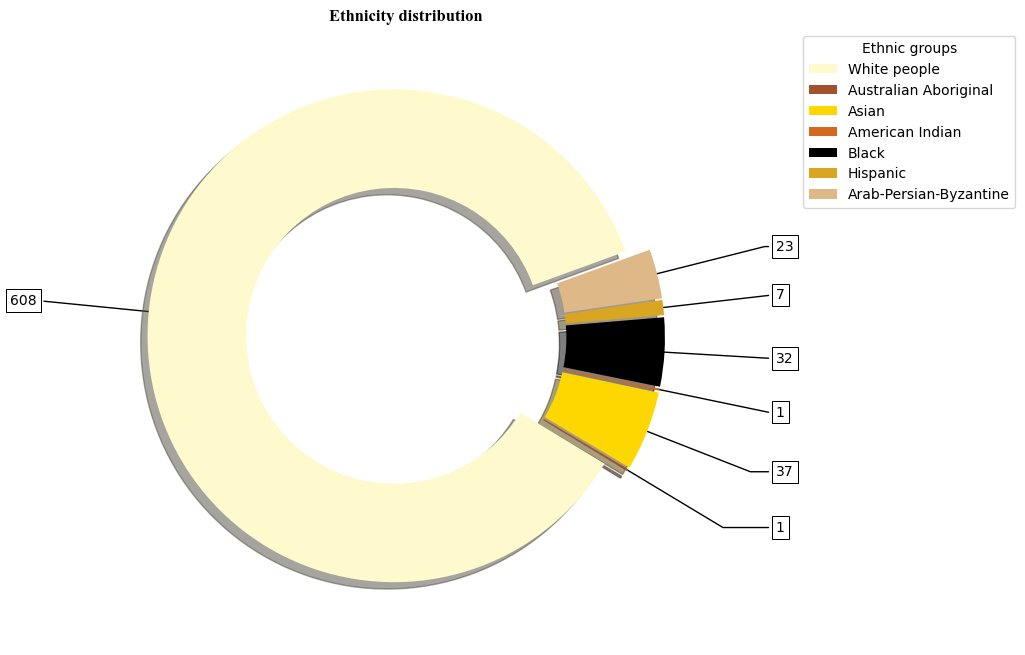

In [5]:
#Vizualise the data
labels2 = 'White people', 'Australian Aboriginal', 'Asian', 'American Indian', 'Black', 'Hispanic', 'Arab-Persian-Byzantine'
people_dist_order = [people_color_dist.iloc[0], people_color_dist.iloc[6],people_color_dist.iloc[1],
                     people_color_dist.iloc[5],people_color_dist.iloc[2],people_color_dist.iloc[4],
                     people_color_dist.iloc[3]]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect='equal'))

wedges, texts = ax.pie(people_dist_order , wedgeprops=dict(width=0.4), startangle=20, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], 
                       colors=sns.color_palette(['lemonchiffon','sienna','gold','chocolate','black','goldenrod','burlywood']),shadow=True)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(people_dist_order[i], xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw)
ax.legend(wedges,labels2, title="Ethnic groups",bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Ethnicity distribution', fontweight= 'bold', fontname='Times New Roman')

plt.show()


The white person's pages appears to be an overwhelming majority. While the other ethnic groups share a sixth of the pages, white people cover 5/6 of the people articles. So Wikispeedia contains more article about white personalities. This results show an inequal representation of the different ethnics groups within the game. With this knowledge, it is now interesting to analyse how this influences the game. Does a person's ethnic group influence the difficulty of the game ? Are certain ethnic groups more widely used or more advantageous ?

As white people are dominant, in a huge part of our analysis, we will group all ethnic groups except whites under other ethnic groups. 

### **3. Target People**

An interesting question that will be our guiding principle is: 

_Does the ethnicity of the person targeted have an influence on the outcome of the game (win or lose)?_

In the first place, it is interesting to look at the proportion of target in each ethnics groups in both paths_finished.tsv and paths_unfinished.tsv. The breakdown is expected to be similar to the previous one.

In [6]:
#Create a dataframe with the path decompose (each cells represents one article of the paths)
path =  paths_finishedDf['path'].str.split(";", expand=True)

#Only keep People's name
people_name= people_color['People']
people_set = set(people_name.tolist())

#Find the path containing article from People's category
people = path.isin(people_set)
rows_with_people = people.any(axis=1)

#Only keep the rows of path which contains at least one people in the path
people_path = path[rows_with_people]

In [7]:
# Find all the path containing a people as FINAL target and extract the starting article corresponding to it 
people_target_finish = []
index_target = []

start_finish= []

for index, row in tqdm(people_path.iterrows()):
    no_none_value = [value for value in row if value != None]
    if no_none_value[-1] in people_name.tolist() :
        people_target_finish.append(no_none_value[-1])
        index_target.append(index)
        start_finish.append(no_none_value[0])


15687it [00:01, 15380.56it/s]


In [8]:
#Count how many times each people are target
people_target_count = pd.Series(people_target_finish).value_counts().reset_index()
people_target_count.columns =['People', 'Count']

#Merge with the original color_people dataframe to have the informations on the ethnicity and category
people_target_df = people_target_count.merge(people_color)
people_target_df = people_target_df[people_target_df['Count'] > 20]

In [9]:
unfinished_target_people = paths_unfinishedDf[paths_unfinishedDf['target'].isin(people_name)]

index_target_unfinish = unfinished_target_people.index
target_unfinish = unfinished_target_people['target']

unfinish = unfinished_target_people['target'].value_counts().reset_index()
unfinish.columns = ['People', 'Count']

#Merge with the original color_people dataframe to have the informations on the ethnicity and category
people_target_unfinish = unfinish.merge(people_color)
people_target_unfinish = people_target_unfinish[people_target_unfinish['Count'] >10]


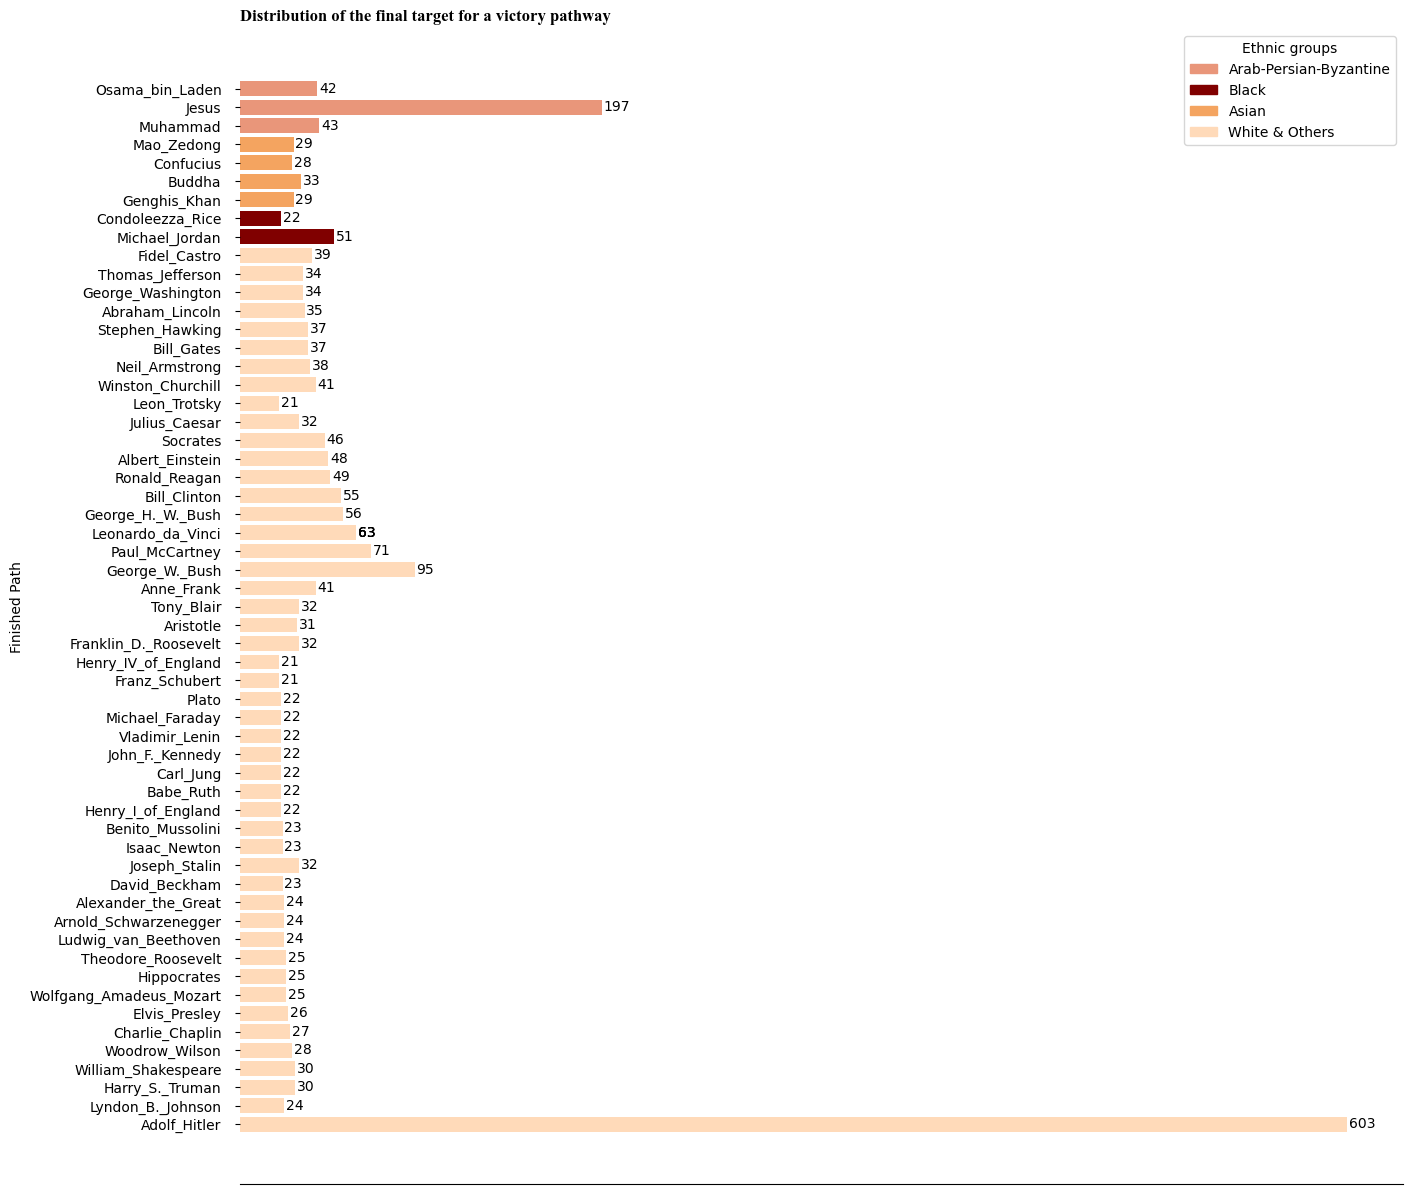

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))

# Sorting the DataFrames
people_target_df = people_target_df.sort_values('Skin Color',ascending=False)
people_target_unfinish = people_target_unfinish.sort_values(by='Skin Color',ascending=False)

# Define colors based on ethnicities
couleur1 = ['darksalmon' if ethnic == 'Arab-Persian-Bizantin' else 'maroon' if ethnic == 'Black' else 'sandybrown' if ethnic == 'Asian' 
            else 'peachpuff' for ethnic in people_target_df['Skin Color']]
couleur2 = ['darksalmon' if ethnic == 'Arab-Persian-Bizantin' else 'maroon' if ethnic == 'Black' else 'sandybrown' if ethnic == 'Asian' 
            else 'peachpuff' for ethnic in people_target_unfinish['Skin Color']]

# Plotting the finished path
ax.barh(people_target_df['People'], people_target_df['Count'], color=couleur1)

# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Add padding between axes and labels
#ax.xaxis.set_tick_params(pad = 5)
ax.xaxis.set_visible(False)
ax.yaxis.set_tick_params(pad = 10)

#ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

ax.set_ylabel('Finished Path')
for i in ax.patches:
    plt.text(i.get_width()+1, i.get_y()+0.2, 
             str(round((i.get_width()), 2)),
             fontsize = 10)
    
ax.set_title('Distribution of the final target for a victory pathway', fontname='Times New Roman', fontweight='bold', loc ='left')

colors = {'Arab-Persian-Byzantine':'darksalmon', 'Black':'maroon', 'Asian':'sandybrown', 'White & Others': 'peachpuff'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles,labels, title= 'Ethnic groups')
plt.show()


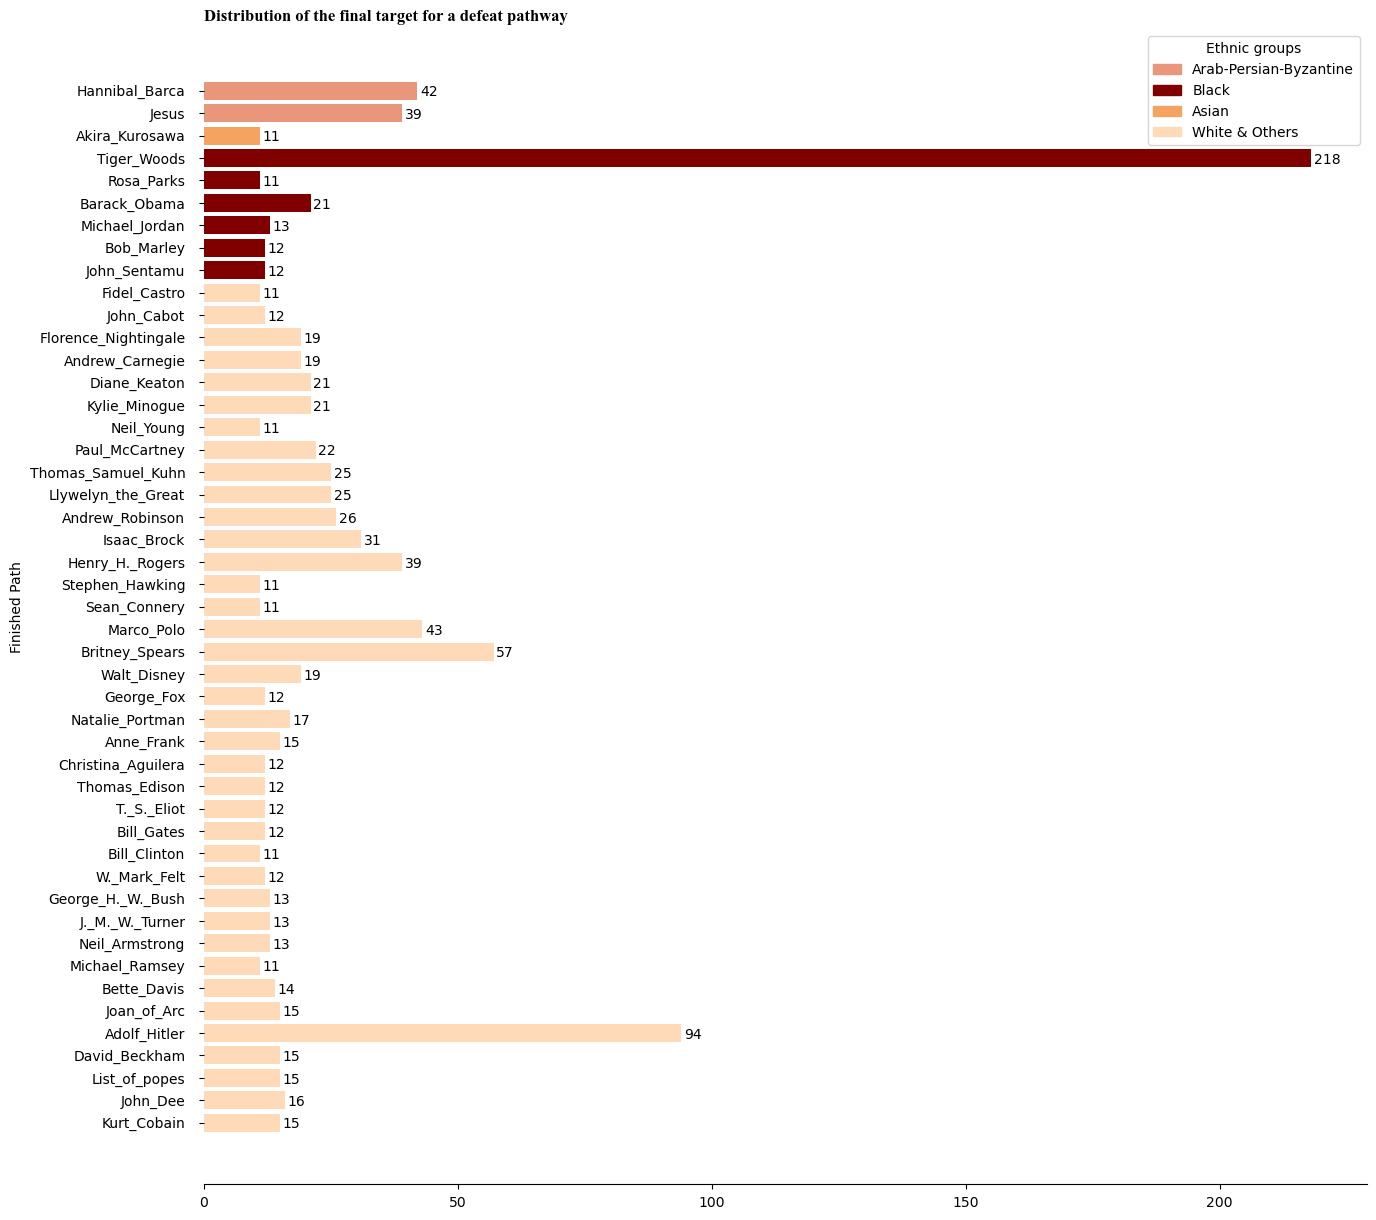

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.barh(people_target_unfinish['People'], people_target_unfinish['Count'], color=couleur2)

# Remove axes splines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

#ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
 
ax.set_ylabel('Finished Path')
for i in ax.patches:
    plt.text(i.get_width()+0.5, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

colors = {'Arab-Persian-Byzantine':'darksalmon', 'Black':'maroon', 'Asian':'sandybrown', 'White & Others': 'peachpuff'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles,labels,title='Ethnic groups')
    
ax.set_title('Distribution of the final target for a defeat pathway', fontname='Times New Roman', fontweight='bold', loc ='left')

plt.show()

So we clearly see, that white people dominate the target of the game with in second positions black people and then east asian an arab people. Some ethnics groups are not even represented in the target such as south east people. 
Some persons are highly target such as Jesus, Adolf Hitler or Tiger Woods. Those extrem values are good to know because they can strongly affect our analysis. But  as they are neither errors nor anomalies and provide crucial information about the game, we have decided not to remove them.


### **4. Study of the difficulty to win depending on the ethnics groups of the target** 

So now, the focus analysis will be the finality of the games : Victory or Defeat depending on the target person. Victory corresponds to paths in the paths_finished.tsv dataset and Defeat corresponds to the paths in paths_unfinished.tsv. 

We define the difficulty of the game principally on its finality : Victory or Defeat. But it might be interesting to also consider the rated difficulty by the players, the duration time of the game and the shortest path length of the game (longer shortest path might be more difficult).

####     **4.1 Naive Analysis**

A naïve analysis is a simplist method to analyze data without considering complex factors that might have an influence. In naïve analysis, means, standard deviation and other statiscal variables are computed without modifying the data and considering all the data.

In the naïve analysis, a comparison of the previous variables of difficulty is done depending on the target ethnic groups.


In [12]:
#Create dataframe containing the games informations for each ethnics groups target
white_people = people_color[people_color['Skin Color'] == 'White']['People'].tolist()
arab_people = people_color[people_color['Skin Color'] == 'Arab-Persian-Bizantin']['People'].tolist()
black_people = people_color[people_color['Skin Color'] == 'Black']['People'].tolist()
asian_people = people_color[people_color['Skin Color'] == 'Asian']['People'].tolist()

white_index =[]
arab_index =[]
black_index =[]
asian_index =[]

for i in range(0, len(index_target)):
    if people_target_finish[i] in white_people :
        white_index.append(index_target[i])

    if people_target_finish[i] in asian_people :
        asian_index.append(index_target[i])

    if people_target_finish[i] in arab_people:
        arab_index.append(index_target[i])

    if people_target_finish[i] in black_people :
        black_index.append(index_target[i])

target_white_path = paths_finishedDf.loc[white_index]
target_arab_path = paths_finishedDf.loc[arab_index]
target_black_path = paths_finishedDf.loc[black_index]
target_asian_path = paths_finishedDf.loc[asian_index]

First, the mean rated difficulty is computed for each ethnic groups

In [13]:
target_white_path.rating.describe()

count    2773.000000
mean        2.230076
std         1.069587
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: rating, dtype: float64

In [14]:
target_black_path.rating.describe()

count    129.000000
mean       2.511628
std        1.016399
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: rating, dtype: float64

In [15]:
target_arab_path.rating.describe()

count    196.000000
mean       2.061224
std        1.139648
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: rating, dtype: float64

In [16]:
target_asian_path.rating.describe()

count    154.000000
mean       2.181818
std        1.019128
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: rating, dtype: float64

Looking at this first estimation, it is difficult to say if white people target's path are less difficult than the others. Indeed, path with for target black people seems the more difficult whereas the one targeting arab people are the easier. So those results can't lead to a conclusion.

Then, the mean duration time of the games are calculated

In [17]:
#Mean duration time for the different ethnics groups target
white_mean_duration= target_white_path['durationInSec'].mean(skipna = True)
arab_mean_duration = target_arab_path['durationInSec'].mean(skipna = True)
black_mean_duration = target_black_path['durationInSec'].mean(skipna = True)
asian_mean_duration = target_asian_path['durationInSec'].mean(skipna = True)

print(f'Mean duration for white people target: { white_mean_duration:.2f} s')
print(f'Mean duration for arab people target: {arab_mean_duration:.2f} s')
print(f'Mean duration for black people target: {black_mean_duration:.2f} s')
print(f'Mean duration for asian people target: {asian_mean_duration:.2f} s')

Mean duration for white people target: 155.94 s
Mean duration for arab people target: 113.98 s
Mean duration for black people target: 153.16 s
Mean duration for asian people target: 138.45 s


The mean duration of the games shows thats the shortest games are the one where arab people are target. This result is consistent with the previous computation of mean difficulty, even if it was quite unexpected. It is difficult to draw conclusions from the other results.

A naïve analysis would be to compare Victory and Defeat for same source and target. Indeed, some games were done many times and don't always have the same finality. So comparing the amount of victory and defeat on some games depending on the target ethnic's groups is a first step to analyze the difficulty.

In [18]:
#Create a dataframe with the path unfinished decompose (each cells represents one article of the paths)
path_unfinished=  paths_unfinishedDf['path'].str.split(";", expand=True)
#Only keep the line of the dataframe unfinish which target a person 
unfinish_target_people = path_unfinished.loc[index_target_unfinish]

#extract the start article of this dataframe
start_unfinish= unfinish_target_people[0]



In [19]:
#Create two dataframe : containing start and end of pathway which target people for defeat and victory
defeat = pd.concat([start_unfinish, target_unfinish], axis=1)
victory = pd.concat([pd.Series(start_finish), pd.Series(people_target_finish)], axis=1)

defeat = defeat.rename(columns= {0 : 'start'})
victory = victory.rename(columns= {0 : 'start', 1 : 'target'})

So now, we have dataframe for victory and defeat where the final article is People. 


In [20]:
#Creating a dataframe with the similar games  won and loose and the amount of victory and defeat in those games.
#Similar games = games with the same start and the same target

df = pd.DataFrame()
df['path'] = defeat.apply(lambda row : '-'.join(row.values.astype(str)), axis =1)
defeat_count= df['path'].value_counts().reset_index()
defeat_count = pd.DataFrame(defeat_count)
defeat_count.columns = ['Start-Target', 'Count']


df1 = pd.DataFrame()
df1['path'] = victory.apply(lambda row : '-'.join(row.values.astype(str)), axis =1)
victory_count= df1['path'].value_counts().reset_index()
victory_count = pd.DataFrame(victory_count)
victory_count.columns = ['Start-Target', 'Count']

similar_game = pd.merge(victory_count, defeat_count, on = ['Start-Target'])
similar_game = similar_game.rename(columns= {'Count_x' : 'Victory', 'Count_y' : 'Defeat'})
similar_game = pd.concat([similar_game['Start-Target'].str.split("-", expand=True), similar_game],axis = 1)
similar_game = similar_game.drop(columns='Start-Target')
similar_game = similar_game.rename(columns={0 : 'Start', 1 : 'People'})
similar_game = pd.merge(similar_game, people_color, on = 'People')
similar_game = similar_game.rename(columns={'People' : 'target', '2_y': 'Category'})
similar_game = similar_game.drop(columns=['2_x', 3])
similar_game

,Start,target,Victory,Defeat,Skin Color,Category
0,Bird,Adolf_Hitler,107,22,White,Political_People
1,Flower,Adolf_Hitler,51,4,White,Political_People
2,Cat,Adolf_Hitler,27,7,White,Political_People
3,Jesus,Adolf_Hitler,24,5,White,Political_People
4,California,Adolf_Hitler,21,5,White,Political_People
...,...,...,...,...,...,...
497,Jordan_River,Miranda_Otto,1,1,White,Actors_models_and_celebrities
498,Potassium_iodide,Breaker_Morant,1,1,White,Historical_figures
499,Airship,James_D._Watson,1,2,White,Human_Scientists
500,Space_Race,Richard_III_of_England,1,1,White,Monarchs_of_Great_Britain


In [21]:
#Count the victory and the defeat for white people target or for other ethnic groups people 
others = similar_game[similar_game['Skin Color'] != 'White']
white = similar_game[similar_game['Skin Color'] != 'Arab']
white = white[white['Skin Color'] != 'Black']
white = white[white['Skin Color'] != 'East Asian']

vic_white = white['Victory'].sum()
def_white = white['Defeat'].sum()
vic_others = others['Victory'].sum()
def_others = others['Defeat'].sum()
print(f"Victory for white people target = {vic_white}")
print(f"Defeat for white people target = {def_white}")
print(f"Victory for white other ethnicity target = {vic_others}")
print(f"Defeat for other ethnicity target = {def_others}")

Victory for white people target = 1506
Defeat for white people target = 738
Victory for white other ethnicity target = 266
Defeat for other ethnicity target = 135


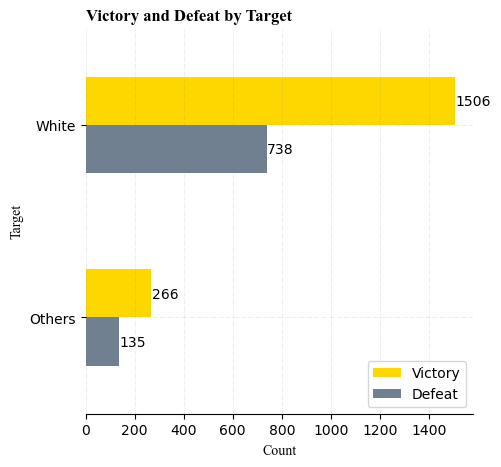

In [22]:
#Vizualise the data
result = pd.DataFrame({
    'Target' : ['White', 'Others'],
    'Victory' : [vic_white, vic_others],
    'Defeat' : [def_white, def_others]
})

fig, ax = plt.subplots(figsize=(5, 5))

# Barres horizontales
result.plot(x='Target', y=['Victory', 'Defeat'], kind="barh", ax=ax, color=['gold', 'slategrey'])

# Personnalisation supplémentaire si nécessaire
ax.set_title('Victory and Defeat by Target',fontname='Times New Roman', fontweight='bold', loc ='left')
ax.set_xlabel('Count',fontname='Times New Roman')
ax.set_ylabel('Target',fontname='Times New Roman')
ax.legend(["Victory", "Defeat"])
ax.invert_yaxis()
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)


# Affichage du graphique
plt.show()


Target white people seems to lead 50% to victory. The gap between victory and defeat for white people target and the other ethnics groups target seems to the same. Thus, the ethnics groups might not influence the finality of the games, surprisingly.
To know if the target person ethnics group has an impact on the result of the game, a statistic test can be achieve on some hypothesis. For example, we can do a Chi-2 test with the following null hypothesis : 
- H0 : There is no significant differences in victories dependanding on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 1506    | 738   |
| Target Other People   | 266    | 135    |

In [23]:
#chi2 test
contingency_table = [[vic_white, def_white], [vic_others, def_others]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(p_value)

0.8044660960156437


p-value>0.05,  so we can't reject the null hypothesis which says that there is no significant differencies in victories depending on the target people ethnicity. This result is unexpected, as we tought that targetting white people leads more to victory.   

A reason for this unexpected result might be the naïve method used. Indeed, the model is more complex and a lot of factor can influence the victory and the defeat, those factors are called **confounders**.




#### **4.2 Analysis considering confounders**

There are some CONFOUNDERS that can affect the finality of the games to victory or defeat : 
- players skills 
- length of the shortest path
- difficulty of the propose games (source to target)
 
To improve the robustness of our previous result, the confounders need to be fixed. To do so,run a **logistic regression** on the model to see which variables impact the most the model is a good solution. 

So the aim is to create a dataframe containing the following columns :   
- Source  
- Target  
- Result : Victory = 1 and Defeat = 0  
- pathway lenght of the player   
- white people article within the pathway  : 1 = Yes and 0 = No
- others ethnic groups article within the pathway   : 1 = Yes and 0 = No 
- duration time of the games   
- nb of games the players has done 
- deviation from the shortest path

After getting the result of the logistic regression, it is possible to obtaine the propensity score of each path. Then we can match the result on the propensity score of the logistic regression to fix the confounders.  
Finally, we decided not to take into account the 'rating' value as it is subjective value since it is given by the player but above all a lot of values are missing, whether for victories or defeats where it has not been attributed.

In [24]:
#Create a list containing all the people with an ethnicity different of white.
others_people = people_skin_color[people_skin_color['Skin Color'] != 'White']
others_people = others_people['People'].tolist()


In [25]:
#Count the total games each players has done
players_finished_path = paths_finishedDf['hashedIpAddress'].value_counts()
players_unfinished_path = paths_unfinishedDf['hashedIpAddress'].value_counts()

players1_df = pd.DataFrame(players_finished_path)
players1_df = players1_df.rename(columns={'count' : 'nb_games_player'})
players2_df = pd.DataFrame(players_unfinished_path)
players2_df = players2_df.rename(columns={'count' : 'nb_games_player'})


We need to extract the shortest path from the file shortest-path-distance-matrix.txt

In [26]:
#open the data corresponding to the shortest path length
shortest_distance_text = np.loadtxt(dataFolder + "shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)

# The Shortest Distance Matrix is created from the imported data
shortest_distance_matrix = [] 
for row in shortest_distance_text:
    row_formated = [] 
    for c in row:
        if c.isdigit(): 
            row_formated.append(int(c))
        else:
            row_formated.append(-1) ## If there is no path between two articles it's represented with -1
        
    shortest_distance_matrix.append(np.array(row_formated))

shortest_distance_matrix = np.array(shortest_distance_matrix)
print(shortest_distance_matrix)

[[ 0 -1 -1 ...  4  4  2]
 [-1  0 -1 ...  3  3  3]
 [-1 -1  0 ...  3  3  3]
 ...
 [-1 -1 -1 ...  0  3  3]
 [-1 -1 -1 ...  4  0  3]
 [-1 -1 -1 ...  3  3  0]]


In [27]:
shortest_distance_df = pd.concat([articlesSeries, pd.DataFrame(shortest_distance_matrix)], axis = 1)

#Rename columns with target articles
col = articlesSeries.tolist()
col.insert(0, 'start')  
shortest_distance_df.columns = col
shortest_distance_df

,start,Áedán_mac_Gabráin,Åland,Édouard_Manet,Éire,Óengus_I_of_the_Picts,€2_commemorative_coins,10th_century,11th_century,12th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
0,Áedán_mac_Gabráin,0,-1,-1,-1,-1,-1,3,3,3,...,4,3,3,4,4,3,4,4,4,2
1,Åland,-1,0,-1,-1,-1,-1,2,2,2,...,4,2,3,4,4,3,4,3,3,3
2,Édouard_Manet,-1,-1,0,-1,-1,-1,3,3,2,...,4,3,2,3,4,3,4,3,3,3
3,Éire,-1,-1,-1,0,-1,-1,3,3,3,...,4,2,2,3,4,3,4,4,3,3
4,Óengus_I_of_the_Picts,-1,-1,-1,-1,0,-1,2,2,3,...,4,2,3,4,4,3,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,Zionism,-1,-1,-1,-1,-1,-1,2,2,2,...,3,2,2,3,3,0,3,3,3,2
4600,Zirconium,-1,-1,-1,-1,-1,-1,3,3,3,...,3,3,2,2,3,3,0,3,4,3
4601,Zoroaster,-1,-1,-1,-1,-1,-1,2,2,2,...,3,2,2,3,4,3,3,0,3,3
4602,Zuid-Gelders,-1,-1,-1,-1,-1,-1,3,3,3,...,4,3,3,4,4,3,5,4,0,3


In [28]:
#Use the function melt to have the previous result in rows instead of matrix form
shortest_distance_df = shortest_distance_df.melt(id_vars='start', value_name='Distance')
shortest_distance_df = shortest_distance_df.rename(columns = {'variable' : 'target'})


shortest_distance_df = shortest_distance_df[shortest_distance_df['Distance'] != -1]
shortest_distance_df = shortest_distance_df[shortest_distance_df['Distance'] != 0]
shortest_distance_df

,start,target,Distance
27624,Áedán_mac_Gabráin,10th_century,3
27625,Åland,10th_century,2
27626,Édouard_Manet,10th_century,3
27627,Éire,10th_century,3
27628,Óengus_I_of_the_Picts,10th_century,2
...,...,...,...
21196810,Zion_National_Park,Zulu,3
21196811,Zionism,Zulu,2
21196812,Zirconium,Zulu,3
21196813,Zoroaster,Zulu,3


First step is to create the dataframe containing all the column enumerate above to run the logistic regression. First we will create a datrame from the paths_finished.tsv and another one for the paths_unfinished.tsv and then we will concatenate them.

In [29]:
#Creating the dataframe with all the desire columns from finished pathway

#first column = source article
df1 =  pd.DataFrame(path[0])

#Find the length, the target and if there is people article in each path
target = []
human_path_length = []
white_people_result = []
other_people_result = []
for index, row in tqdm(path.iterrows()):
    no_none_value=[]
    for value in row :
        if value != None : 
            no_none_value.append(value)
    length = len(no_none_value)
    target.append(no_none_value[-1])
    human_path_length.append(length)
    if any(value in white_people for value in no_none_value):
        white_people_result.append(1)
    else:
        white_people_result.append(0)
    if any(value in others_people for value in no_none_value):
        other_people_result.append(1)
    else:
        other_people_result.append(0)

target_df = pd.DataFrame(target, columns = ['Target'])
human_path_length = pd.DataFrame(human_path_length, columns = ['human_path_length'])
w_people = pd.DataFrame(white_people_result)
o_people = pd.DataFrame(other_people_result)
w_people.columns = ['white_in_pathway']
o_people.columns = ['others_in_pathway']

df1= pd.merge(df1, target_df, left_index=True, right_index=True)
df1= pd.merge(df1, human_path_length, left_index=True, right_index=True)
df1 = pd.merge(df1, w_people,  left_index=True, right_index=True)
df1 = pd.merge(df1, o_people,  left_index=True, right_index=True)

df1 = df1.rename(columns={0: 'Source'})
df1 = pd.merge(df1, paths_finishedDf[['hashedIpAddress', 'durationInSec']], left_index=True, right_index=True)
df1 = pd.merge(df1, players1_df, on = ['hashedIpAddress'])

# Merge the results into df1
shortest_distance_df = shortest_distance_df.rename(columns={'start': 'Source', 'target': 'Target', 'Distance' : 'Shortest_path'})
df1 = pd.merge(df1, shortest_distance_df, on=['Source', 'Target'], how='inner')
df1 = df1.drop(columns=['hashedIpAddress'])

df1['deviation_path'] = df1['human_path_length'] - df1['Shortest_path']
df1

51317it [00:05, 8845.60it/s]


,Source,Target,human_path_length,white_in_pathway,others_in_pathway,durationInSec,nb_games_player,Shortest_path,deviation_path
0,14th_century,African_slave_trade,5,0,0,88,13,3,2
1,14th_century,African_slave_trade,8,0,0,138,43,3,5
2,Bird,Adolf_Hitler,4,1,0,45,13,2,2
3,Bird,Adolf_Hitler,7,1,0,137,4865,2,5
4,Bird,Adolf_Hitler,5,1,0,370,8,2,3
...,...,...,...,...,...,...,...,...,...
49320,Earwax,Sperm_Whale,4,0,0,21,1,2,2
49321,Fugu,Missouri_River,4,0,0,32,1,2,2
49322,Lego,Caribbean_Sea,4,0,0,131,2,2,2
49323,Lego,Caribbean_Sea,4,0,0,74,2,2,2


In [30]:
#Same as before but to create a dataframe from with unfinished path
df2 = pd.DataFrame(path_unfinished[0])
df2 = pd.merge(df2, paths_unfinishedDf['target'], left_index=True, right_index=True)
df2 = df2.rename(columns={0: 'Source', 'target': 'Target'})

human_path_length2 = []
white_people_result2 = []
other_people_result2 = []
for index, row in tqdm(path_unfinished.iterrows()):
    no_none_value=[]
    for value in row :
        if value != None : 
            no_none_value.append(value)
    length = len(no_none_value)
    human_path_length2.append(length)
    
    if any(value in white_people for value in no_none_value):
        white_people_result2.append(1)
    else:
        white_people_result2.append(0)

    if any(value in others_people for value in no_none_value):
        other_people_result2.append(1)
    else:
        other_people_result2.append(0)

human_path_length2 = pd.DataFrame(human_path_length, columns = ['human_path_length'])
w_people2 = pd.DataFrame(white_people_result2)
o_people2 = pd.DataFrame(other_people_result2)
w_people2.columns = ['white_in_pathway']
o_people2.columns = ['others_in_pathway']


df2= pd.merge(df2, human_path_length2, left_index=True, right_index=True)
df2 = pd.merge(df2, w_people2,  left_index=True, right_index=True)
df2 = pd.merge(df2, o_people2,  left_index=True, right_index=True)
df2 = pd.merge(df2, paths_unfinishedDf[['hashedIpAddress', 'durationInSec']], left_index=True, right_index=True)
df2 = pd.merge(df2, players2_df, on = ['hashedIpAddress'])


shortest_distance_df = shortest_distance_df.rename(columns={'start': 'Source', 'target': 'Target'})
df2 = pd.merge(df2, shortest_distance_df, on=['Source', 'Target'], how='inner')
df2['deviation_path'] = df2['human_path_length'] - df2['Shortest_path']
df2 = df2.drop(columns=['hashedIpAddress'])
df2

24874it [00:02, 12295.72it/s]


,Source,Target,human_path_length,white_in_pathway,others_in_pathway,durationInSec,nb_games_player,Shortest_path,deviation_path
0,Julius_Caesar,Caracas,5,1,0,1805,1,3,2
1,Malawi,First_Crusade,8,1,0,1818,1,3,5
2,Paraguay,Mount_St._Helens,4,0,0,49,2,3,1
3,Paraguay,Mount_St._Helens,7,0,0,1808,2,3,4
4,Agriculture,Grand_Canal_of_China,6,0,0,2009,1,3,3
...,...,...,...,...,...,...,...,...,...
22648,Wine,History_of_post-Soviet_Russia,4,0,0,72,15,3,1
22649,Turks_and_Caicos_Islands,Iraq_War,6,0,0,182,15,3,3
22650,Franz_Kafka,Cholera,5,1,0,180,15,3,2
22651,Modern_history,Hollandic,8,0,0,6,1,3,5


In [31]:
#Merge the previous dataframe into a single df with a new column 'Result' (Victory = 1 and Defeat = 0)
df1['Result'] = 1
df2['Result'] = 0

#we only keep the path containing people article
df1= df1[(df1['white_in_pathway'] != 0) | (df1['others_in_pathway'] != 0)]
df2= df2[(df2['white_in_pathway'] != 0) | (df2['others_in_pathway'] != 0)]

#Merging the df
df = pd.concat([df1, df2])  
df.reset_index(drop=True, inplace=True)
df

,Source,Target,human_path_length,white_in_pathway,others_in_pathway,durationInSec,nb_games_player,Shortest_path,deviation_path,Result
0,Bird,Adolf_Hitler,4,1,0,45,13,2,2,1
1,Bird,Adolf_Hitler,7,1,0,137,4865,2,5,1
2,Bird,Adolf_Hitler,5,1,0,370,8,2,3,1
3,Bird,Adolf_Hitler,6,1,0,183,30,2,4,1
4,Bird,Adolf_Hitler,4,1,0,39,6,2,2,1
...,...,...,...,...,...,...,...,...,...,...
19986,Order_of_the_Bath,List_of_popes,9,1,0,161,15,3,6,0
19987,Breaker_Morant,Eurovision_Song_Contest,5,1,0,378,15,3,2,0
19988,Shaka,July_2006_Java_earthquake,17,1,1,292,15,4,13,0
19989,Sardar_Vallabhbhai_Patel,Mauthausen-Gusen_concentration_camp,4,1,1,291,15,4,0,0


From this new dataframe, we can now compute the logistic regression to see, how each variables influence the model and so the categorical variable 'Result'.

In [32]:
#Running the Logistic Regression
mod = smf.logit(formula='Result ~  durationInSec + nb_games_player + C(white_in_pathway) + C(others_in_pathway)+ Shortest_path + deviation_path',
              data=df)

res = mod.fit()

# Extract the estimated propensity scores for each rows
df['Propensity_score'] = res.predict()
df['Propensity_score'] = df['Propensity_score'].round(3)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.386720
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                19991
Model:                          Logit   Df Residuals:                    19984
Method:                           MLE   Df Model:                            6
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                  0.2995
Time:                        14:55:51   Log-Likelihood:                -7730.9
converged:                       True   LL-Null:                       -11036.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.8171      0.161     17.545      0.000       2

Looking at the logistic regression, the variables which influence the most the model seems to be the presence of people's (white or others ethnicity) article and the shortest path. This result is quite expected as we define our confounders as the shortest path, the skills of the players. The last one is more difficult to represent has we don't have informations on the players : we can only assume the number of games each players has done based on the IP adress, the duration of each game and the deviation from the shortest path.

In [33]:
#function to match the data when they have the exact same propensity score
def get_similarity(propensity_1, propensity_2):
    if (propensity_1 == propensity_2) : 
        return 1 
    else: 
        return 0

In [34]:
# Separate the treatment (a : pathway with white people article) and 
# control groups (b : pathway with others etchnicity people article)
a = df[(df['white_in_pathway'] == 1) & (df['others_in_pathway'] == 0)]
b = df[(df['white_in_pathway'] == 0) & (df['others_in_pathway'] == 1)]

In [35]:
# Create an empty undirected graph
G = nx.Graph()

for index_a, score_a in a['Propensity_score'].items():
    for index_b, score_b in b['Propensity_score'].items():
        similarity = get_similarity(score_a, score_b)
        if similarity == 1:
            G.add_weighted_edges_from([(index_a, index_b, similarity)])


In [36]:
# the layout of the matching is : row[n] is matched with row[n+1] 
matching = nx.min_weight_matching(G)
matched = list()
for i in matching: 
    matched = matched + [i[0]] + [i[1]]

Finally, we can match the data. We decided to match on path containing a white people article and one path containing an other ethnicity people on the propensity score of each path. The goal is to analyze the distribution of victory or defeat.

In [37]:
#create the matched dataframe
matched_df = df.iloc[matched]
matched_df

,Source,Target,human_path_length,white_in_pathway,others_in_pathway,durationInSec,nb_games_player,Shortest_path,deviation_path,Result,Propensity_score
16315,Swift,Actor,8,1,0,180,6,3,5,0,0.831
7877,Chew_Valley_Lake,Muhammad,6,0,1,54,1,3,3,1,0.831
15871,J._R._R._Tolkien,Polymerase_chain_reaction,15,1,0,132,3,3,12,0,0.917
8245,Telephone,Ming_Dynasty,5,0,1,35,35,2,3,1,0.917
14745,Electrical_resistance,History,5,1,0,105,1,3,2,1,0.808
...,...,...,...,...,...,...,...,...,...,...,...
4607,Sun_Yat-sen,Silicon,7,0,1,148,3,3,4,1,0.815
13008,Yuri_Gagarin,Grand_Canal_of_China,7,1,0,171,2,3,4,1,0.816
14472,Abhidhamma_Pitaka,Mozambique,9,0,1,227,1,3,6,1,0.816
18743,Johann_Sebastian_Bach,Ununbium,6,1,0,76,2,3,3,0,0.834


In [38]:
#counting the defeat and victory in each case
victory_w = 0
victory_o = 0
defeat_w = 0
defeat_o = 0
for index, row in matched_df.iterrows() :
    if row['white_in_pathway'] == 1 and  row['Result'] == 1: 
        victory_w += 1
    if row['others_in_pathway'] == 1 and  row['Result'] == 1: 
        victory_o += 1
    if row['white_in_pathway'] == 1 and  row['Result'] == 0: 
        defeat_w += 1
    if row['others_in_pathway'] == 1 and  row['Result'] == 0: 
        defeat_o += 1


<function matplotlib.pyplot.show(close=None, block=None)>

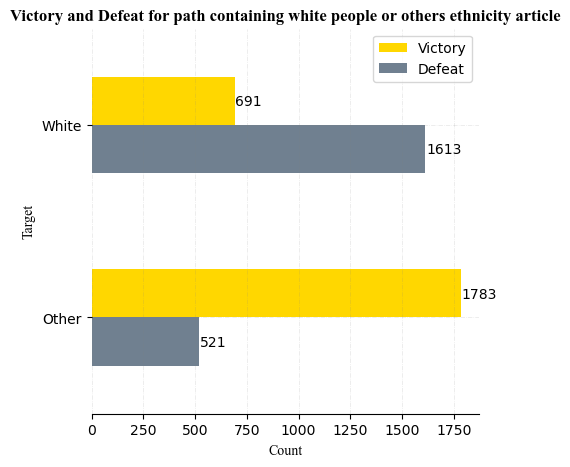

In [39]:
result = pd.DataFrame({
    'Target' : ['White', 'Other'],
    'Victory' : [victory_w, victory_o],
    'Defeat' : [defeat_w, defeat_o]
})


fig, ax = plt.subplots(figsize=(5, 5))

# Barres horizontales
result.plot(x='Target', y=['Victory', 'Defeat'], kind="barh", ax=ax, color=['gold', 'slategrey'])

# Personnalisation supplémentaire si nécessaire
ax.set_title('Victory and Defeat for path containing white people or others ethnicity article',fontname='Times New Roman', fontweight='bold', loc ='center')
ax.set_xlabel('Count',fontname='Times New Roman')
ax.set_ylabel('Target',fontname='Times New Roman')
ax.legend(["Victory", "Defeat"])
ax.invert_yaxis()
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

plt.show

The result are completely unexpected, it seems clear that passing through a other ethnicity people article leads more to victory. Whereas passing through white people article lead more to defeat.  
However, here we're looking at the paths containing at some moment a people article. But on each path, several article are passed through, each article belonging to a different category and therefore each of them can strongly affect influence the difficulty of the game. 
Thus, to try and get better results, we will focus, as we said earlier, on the pahtway targeting people article without considering the article within pathway.  

We start again the logistic regression but on a dataframe containing only the pathway targetting People article and we focus our study on is it easier to win if we target a white people or another ethnicity people.

In [40]:
#from the previous dataframe, only keep the pathway targetting people
filtered_df1 = df1[df1['Target'].isin(people_target_finish)]
filtered_df2 = df2[df2['Target'].isin(people_name)]


filtered_df1 = filtered_df1.drop(columns=['white_in_pathway'])
filtered_df2 = filtered_df2.drop(columns=['white_in_pathway'])
filtered_df1 = filtered_df1.drop(columns=['others_in_pathway'])
filtered_df2 = filtered_df2.drop(columns=['others_in_pathway'])


filtered_df1['white_target'] = filtered_df1['Target'].isin(white_people)
filtered_df1['others_target'] = filtered_df1['Target'].isin(others_people)
filtered_df2['white_target'] = filtered_df2['Target'].isin(white_people)
filtered_df2['others_target'] = filtered_df2['Target'].isin(others_people)

filtered_df1['white_target'] = filtered_df1['white_target'].replace({True: 1, False: 0})
filtered_df1['others_target'] = filtered_df1['others_target'].replace({True: 1, False: 0})
filtered_df2['white_target'] = filtered_df2['white_target'].replace({True: 1, False: 0})
filtered_df2['others_target'] = filtered_df2['others_target'].replace({True: 1, False: 0})

#merge to have the final dataframe
df_people_target = pd.concat([filtered_df1, filtered_df2])  
df_people_target.reset_index(drop=True, inplace=True)
df_people_target


,Source,Target,human_path_length,durationInSec,nb_games_player,Shortest_path,deviation_path,Result,white_target,others_target
0,Bird,Adolf_Hitler,4,45,13,2,2,1,1,0
1,Bird,Adolf_Hitler,7,137,4865,2,5,1,1,0
2,Bird,Adolf_Hitler,5,370,8,2,3,1,1,0
3,Bird,Adolf_Hitler,6,183,30,2,4,1,1,0
4,Bird,Adolf_Hitler,4,39,6,2,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...
6473,James_Callaghan,Henry_H._Rogers,7,18,2,3,4,0,1,0
6474,Ronald_Reagan,Bob_Marley,6,21,2,3,3,0,0,1
6475,Architecture,Osama_bin_Laden,9,1844,1,3,6,0,0,1
6476,Mercantilism,List_of_popes,4,172,4,4,0,0,1,0


In [41]:
mod = smf.logit(formula='Result ~ durationInSec + nb_games_player + C(white_target) + C(others_target)+ Shortest_path + deviation_path',
              data=df_people_target)

res = mod.fit()

# Extract the estimated propensity scores
df_people_target['Propensity_score'] = res.predict()
df_people_target['Propensity_score'] = df_people_target['Propensity_score'].round(3)

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.244126
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                 6478
Model:                          Logit   Df Residuals:                     6471
Method:                           MLE   Df Model:                            6
Date:                Thu, 21 Dec 2023   Pseudo R-squ.:                  0.3361
Time:                        14:58:33   Log-Likelihood:                -1581.5
converged:                       True   LL-Null:                       -2382.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.1074        nan        nan        nan         nan        

As before, the variables influencing the most the model are the shortest path length and the ethnicity of the target people. Let's fixed the confounders based on the propensity score

In [42]:
# Separate the treatment and control groups
a_target = df_people_target[(df_people_target['white_target'] == 1) & (df_people_target['others_target'] == 0)]
b_target = df_people_target[(df_people_target['white_target'] == 0) & (df_people_target['others_target'] == 1)]

In [43]:
# Create an empty undirected graph
G = nx.Graph()

for index_a, score_a in a_target['Propensity_score'].items():
    for index_b, score_b in b_target['Propensity_score'].items():
        similarity = get_similarity(score_a, score_b)
        if similarity == 1:
            G.add_weighted_edges_from([(index_a, index_b, similarity)])

In [44]:
# the layout of the matching is : row[n] is matched with row[n+1] 
matching2 = nx.min_weight_matching(G)
matched2 = []
for i in matching2: 
    matched2 = matched2 + [i[0]] + [i[1]]

In [45]:
matched_target_df = df_people_target.iloc[matched2]
matched_target_df

,Source,Target,human_path_length,durationInSec,nb_games_player,Shortest_path,deviation_path,Result,white_target,others_target,Propensity_score
6125,Scotland,John_Cabot,8,313,3,2,6,0,1,0,0.949
1284,Karl_Popper,Nelson_Mandela,5,119,1,2,3,1,0,1,0.949
2252,List_of_Test_cricket_triple_centuries,Woodrow_Wilson,9,111,545,4,5,1,1,0,0.997
2143,Stratford-upon-Avon,Tenzing_Norgay,23,299,545,4,19,1,0,1,0.997
5995,Charles_Etienne_Brasseur_de_Bourbourg,Isaac_Brock,5,180,2,4,1,0,1,0,0.802
...,...,...,...,...,...,...,...,...,...,...,...
3208,The_Origin_of_Species,Gautama_Buddha,4,22,5,2,2,1,0,1,0.959
3018,Mario,George_Washington,3,138,5,2,1,1,1,0,0.954
2302,Mahatma_Gandhi,Jesus,9,196,3,2,7,1,0,1,0.954
6040,Electricity,Anne_Frank,5,109,5,3,2,0,1,0,0.920


In [46]:
#Counting the victory and the result when targetting white people and other ethnicity people
victory_w = 0
victory_o = 0
defeat_w = 0
defeat_o = 0

for index, row in matched_target_df.iterrows() :
    if row['white_target'] == 1 and  row['Result'] == 1: 
        victory_w += 1
    if row['others_target'] == 1 and  row['Result'] == 1: 
        victory_o += 1
    if row['white_target'] == 1 and  row['Result'] == 0: 
        defeat_w += 1
    if row['others_target'] == 1 and  row['Result'] == 0: 
        defeat_o += 1

<function matplotlib.pyplot.show(close=None, block=None)>

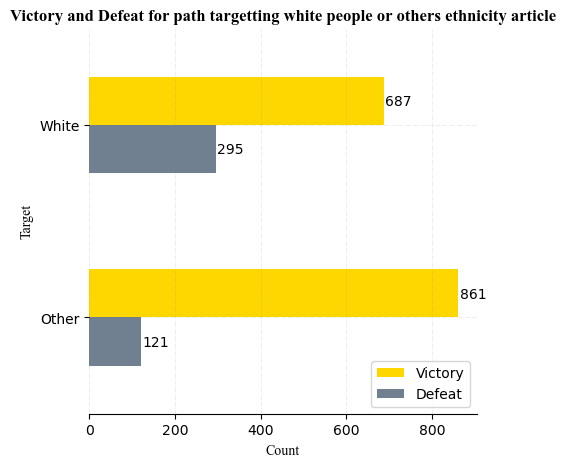

In [47]:
result = pd.DataFrame({
    'Target' : ['White', 'Other'],
    'Victory' : [victory_w, victory_o],
    'Defeat' : [defeat_w, defeat_o]
})


fig, ax = plt.subplots(figsize=(5, 5))

# Barres horizontales
result.plot(x='Target', y=['Victory', 'Defeat'], kind="barh", ax=ax, color=['gold', 'slategrey'])

# Personnalisation supplémentaire si nécessaire
ax.set_title('Victory and Defeat for path targetting white people or others ethnicity article',fontname='Times New Roman', fontweight='bold', loc ='center')
ax.set_xlabel('Count',fontname='Times New Roman')
ax.set_ylabel('Target',fontname='Times New Roman')
ax.legend(["Victory", "Defeat"])
ax.invert_yaxis()
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid( color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)

for i in ax.patches:
    plt.text(i.get_width()+3, i.get_y()+0.15, 
             str(round((i.get_width()), 2)),
             fontsize = 10)

plt.show

While targetting people, the result are less obivous, but it still seems easier to win while targetting other ethnicity people article. However it is possible to check statistically this conclusion by running a statistic test on hypothesis. For example, we can do a Chi-2 test with the following null hypothesis : 
- H0 : There is no significant differences in victories dependanding on the target people (white or others)' 
- H1 : There is a significant differences in victories depending on the target people (white or others)'

|  | Victory | Defeat |
|-----------|-----------|-----------|
| Target White People  | 687    | 295   |
| Target Other People   | 861  | 121   |

In [48]:
#chi-2 test
contingency_table = [[victory_w, defeat_w], [victory_o, defeat_o]]

_, p_value, _, _ = chi2_contingency(contingency_table)
print(f"p-value = {p_value}")

p-value = 1.2479734806279246e-21


p-value < 0.05. So we can reject the null hypothesis and so there is a signicant differences between in the result while targetting a white people or an other ethnicity people. Thus surprisingly targetting other ethnicity people seems to lead more to victory than targetting white people.




Now, we wanted to understand the origin of this differences. Why some target lead more to victory than to defeat ? Is this the case because some articles are more attractive or better written? Is this because the link distribution in and out the articles is unequal ? Or is this due to global knowledge ? 

So we're going to explore those few questions to try and find the origin of this difference.

### **5. What is the origin of this inequality/difference in the final result?**

#### **5.1 Sentiment Analysis**

Maybe the players are more attract by positive article, and succeed better in the game when they are confront to positive pages rather than negative one. So we decide torun **sentiment analysis** on the people article.

In [49]:
plainTextFolder = '../../Data/plaintext_articles/'

In [50]:
people_skin_color2 = pd.read_csv(dataFolder + 'ethnic_category.tsv', header=1, sep= '\t' )
people_skin_color2.columns = ['Category', 'People', 'Skin Color']
people_skin_color2['People'] = people_skin_color2['People'].map(lambda x : x.replace("%20", "_"))
corpus = []
titles =[]
for title in people_skin_color2['People'] : 
    corpus.append(plainTextFolder+title+'.txt')
    titles.append(title)
df_sentiment = pd.DataFrame(data = titles, columns = ['People'])
df_sentiment['Skin Color'] = people_skin_color2['Skin Color']
df_sentiment['Skin Color' ] = df_sentiment['Skin Color'].apply(lambda x : 'Others' if x != 'White' else x)

We are now shifting our focus to sentiment analysis. We aim to determine whether we can distinguish a 'White' page from a page of another ethnicity based on sentiment analysis results. To start, we will use Vader for sentiment analysis.

Vader provides three output values: positive_rate, negative_rate, and compound_rate. Positive_rate represents the percentage of the article's content that is deemed positive, while negative_rate reflects the percentage of negative content. The neutral_rate, on the other hand, signifies the proportion of neutral content within the article."

In [51]:
df_sentiment['Positive_rate'] = [0 for i in range(len(df_sentiment))]
df_sentiment['Negative_rate'] = [0 for i in range (len(df_sentiment))]
df_sentiment['neutral_rate'] = [0 for i in range(len(df_sentiment))]
df_sentiment['Positive_rate'] = df_sentiment['Positive_rate'].astype(float)
df_sentiment['Negative_rate'] = df_sentiment['Negative_rate'].astype(float)
df_sentiment['neutral_rate'] = df_sentiment['neutral_rate'].astype(float)

analyzer = SentimentIntensityAnalyzer()
for i in range(len(corpus)):
    with  open(corpus[i]) as page:
        page_score = analyzer.polarity_scores(page.read())
        df_sentiment.at[i, 'Positive_rate'] = page_score.get('pos')
        df_sentiment.at[i, 'Negative_rate'] = page_score.get('neg')
        df_sentiment.at[i, 'neutral_rate'] = page_score.get('neu')


df_sentiment.head(5)

,People,Skin Color,Positive_rate,Negative_rate,neutral_rate
0,%C3%93engus_I_of_the_Picts,White,0.039,0.090,0.871
1,Abbas_I_of_Persia,Others,0.101,0.063,0.836
2,Adam_Smith,White,0.159,0.058,0.783
3,Adriaen_van_der_Donck,White,0.085,0.072,0.843
4,Agamemnon,White,0.066,0.114,0.820


Our primary goal is to determine whether articles from a specific ethnic category tend to be more negative or positive on average compared to others. This is why we start by plotting each article based on its negative rate and positive rate. Subsequently, we will conduct a statistical analysis.

To represent the data, we will reduce the dimensionality to two using the PCA algorithm, allowing us to visualize them in two dimensions.

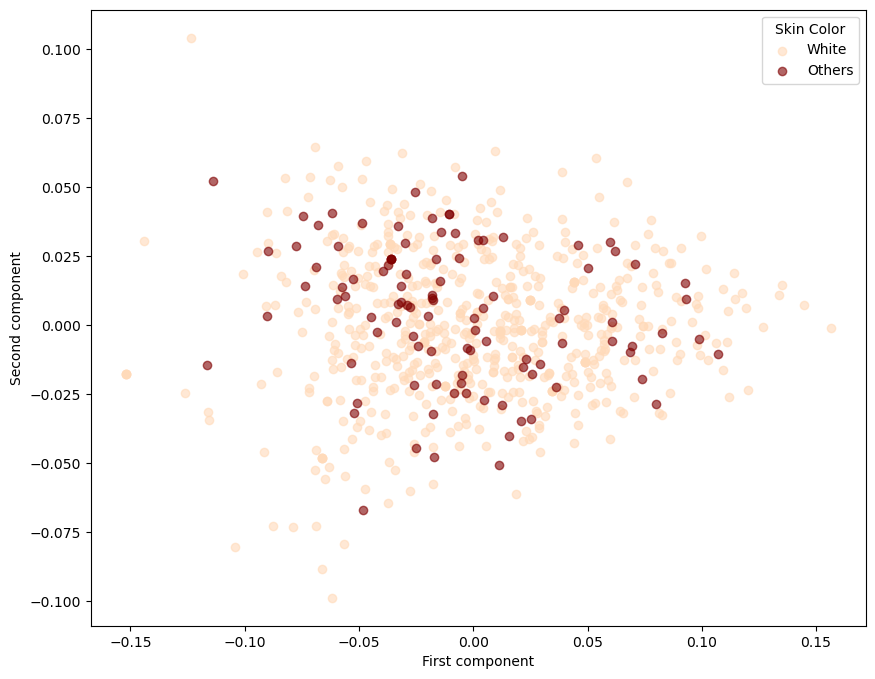

In [52]:
df_pca = PCA(n_components=2).fit(df_sentiment[['Positive_rate','Negative_rate','neutral_rate']]).transform(df_sentiment[['Positive_rate','Negative_rate','neutral_rate']])
df_pca = pd.DataFrame(df_pca, columns=['first_component', 'second_component'])
df_sentiment['first_component'] = df_pca['first_component']
df_sentiment['second_component'] = df_pca['second_component']

#plot the scatter graph
custom_colors = {'White': 'peachpuff', 'Others': 'maroon'}

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a custom color to each 'Skin Color' category
for skin_color in custom_colors:
    subset = df_sentiment[df_sentiment['Skin Color'] == skin_color]
    ax.scatter(subset['first_component'], subset['second_component'], 
               label=skin_color, c=custom_colors[skin_color], alpha=0.6)

# Set the axis labels
ax.set_xlabel("First component")
ax.set_ylabel("Second component")

# Add a legend
ax.legend(title='Skin Color')


# Show the plot
plt.show()

In [53]:
df_sentiment[['Skin Color', 'Positive_rate', 'Negative_rate', 'neutral_rate']].groupby(by = ['Skin Color']).describe()

Positive_rate                                                   \
                   count      mean       std    min     25%    50%    75%   
Skin Color                                                                  
Others             103.0  0.093854  0.022310  0.048  0.0785  0.094  0.109   
White              608.0  0.094171  0.027663  0.030  0.0760  0.093  0.110   

                  Negative_rate            ...                neutral_rate  \
              max         count      mean  ...     75%    max        count   
Skin Color                                 ...                               
Others      0.161         103.0  0.074942  ...  0.1005  0.154        103.0   
White       0.192         608.0  0.067306  ...  0.0860  0.194        608.0   

                                                                     
                mean       std    min    25%    50%      75%    max  
Skin Color                                                           
Others      0.831282  0.038194  0.742  0.809  0.825  0.85100  0.925  
White       0.838530  0.041912  0.713  0.809  0.836  0.86725  0.965  

[2 rows x 24 columns]

One thing we can notice is that Wikispeedia's articles are mostly written with a neutral tone.

Let use a t-test to see if the null hypothesis that the average of White is greater or lower is significant.

In [54]:
stats.ttest_ind(df_sentiment.loc[df_sentiment['Skin Color'] == 'White']['neutral_rate'], df_sentiment.loc[df_sentiment['Skin Color'] == 'Others']['neutral_rate'] )

TtestResult(statistic=1.6431809250118232, pvalue=0.10078886906171104, df=709.0)

p-value > 0.05 for the neutral rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [55]:
stats.ttest_ind(df_sentiment.loc[df_sentiment['Skin Color'] == 'White']['Positive_rate'], df_sentiment.loc[df_sentiment['Skin Color'] == 'Others']['Positive_rate'] )

TtestResult(statistic=0.1102480158106677, pvalue=0.9122438817995863, df=709.0)

p-value > 0.05 for the positive rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [56]:
stats.ttest_ind(df_sentiment.loc[df_sentiment['Skin Color'] == 'White']['Negative_rate'], df_sentiment.loc[df_sentiment['Skin Color'] == 'Others']['Negative_rate'] )

TtestResult(statistic=-2.5330680591489454, pvalue=0.011521372409871456, df=709.0)

p-value <0.05 for the negative rate, indicating a significant difference between articles categorized as 'white' and 'others' on average. However, it's worth noting that it's the articles attributed to the 'white' category that seem to be negatively impacted.

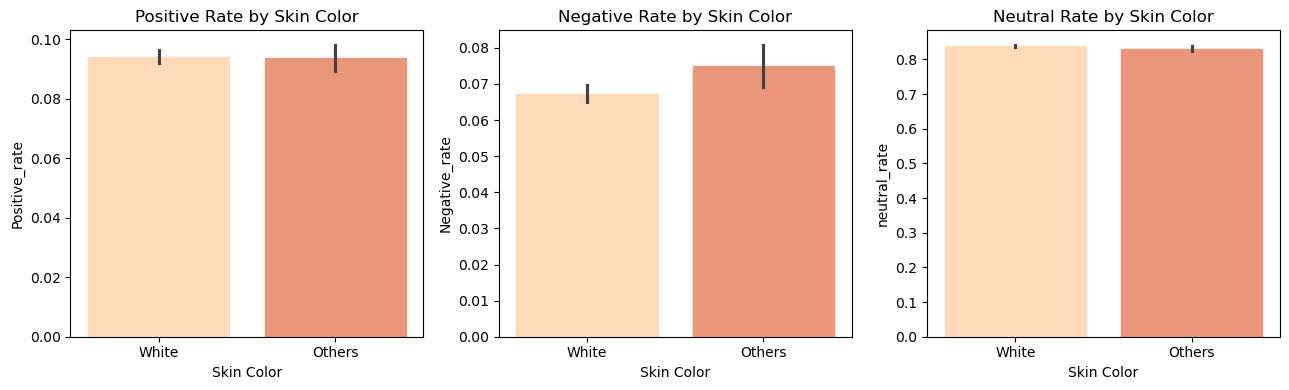

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# First bar plot for Positive_rate
ax1 = sns.barplot(x="Skin Color", y="Positive_rate", data=df_sentiment, ax=axes[0])
ax1.set_title("Positive Rate by Skin Color")
for bar, skin_color in zip(ax1.patches, df_sentiment["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Second bar plot for Negative_rate
ax2 = sns.barplot(x="Skin Color", y="Negative_rate", data=df_sentiment, ax=axes[1])
ax2.set_title("Negative Rate by Skin Color")
for bar, skin_color in zip(ax2.patches, df_sentiment["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Third bar plot for Neutral_rate
ax3 = sns.barplot(x="Skin Color", y="neutral_rate", data=df_sentiment, ax=axes[2])
ax3.set_title("Neutral Rate by Skin Color")
for bar, skin_color in zip(ax3.patches, df_sentiment["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

plt.tight_layout()
plt.show()

Now, let's attempt a more in-depth analysis. Firstly, the categories to which the articles belong can significantly influence Vader's sentiment evaluation. For instance, if an article discusses a character involved in a war, it's expected to be more negative compared to an article about an artist, for example. To mitigate this effect, we will perform perfect matching based on the categories.

<Figure size 2000x1500 with 0 Axes>

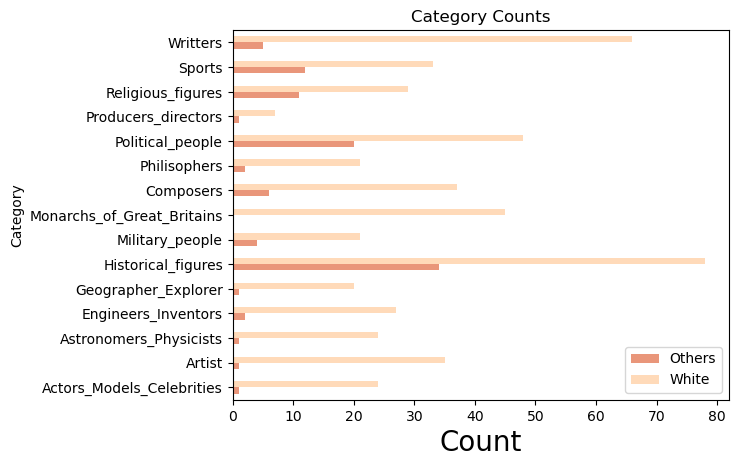

In [59]:
#let see the proportion of Skin Color in each categories.
people_skin_color2['People'].map(lambda x : unquote(x,'utf-8'))
white_skin_color = people_skin_color.loc[people_skin_color2['Skin Color'] == 'White']
other_skin_color = people_skin_color.loc[people_skin_color2['Skin Color'] != 'White']
white_skin_color = white_skin_color[['Category','Skin Color']].groupby(['Category'], as_index = False).count()
other_skin_color = other_skin_color[['Category','Skin Color']].groupby(['Category'], as_index= False).count()
other_skin_color.columns = ['Category', 'Others']
white_skin_color.columns = ['Category', 'White']
category_df = other_skin_color.merge(white_skin_color, how='left', left_on=['Category'], right_on=['Category'])
category_df.index = ['Actors_Models_Celebrities', 'Artist', 'Astronomers_Physicists', 'Engineers_Inventors', 'Geographer_Explorer', 'Historical_figures', 'Military_people', 'Monarchs_of_Great_Britains',
'Composers', 'Philisophers', 'Political_people', 'Producers_directors','Religious_figures', 'Sports', 'Writters']
# Creating a horizontal bar plot
plt.figure(figsize=[20, 15])
category_df.plot(kind='barh', color=['darksalmon', 'peachpuff'])

# Setting titles and labels with specified font sizes
plt.title('Category Counts')
plt.ylabel('Category', fontsize=10)
plt.xlabel('Count', fontsize=20)
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.xticks(fontsize=10)   # Adjust font size for x-axis labels

# Displaying the plot
plt.show()
category_df.index = category_df['Category']

In [60]:
#remove cofounder category, we should try to match only white and other with same category : (sport player, politician,...)
#first we need to define a distance function for EXACT matching
def get_similarity(category_a, category_b):
    if (category_a.item() == category_b.item()): 
        return 1 
    else: 
        return 0    

In [61]:
#Create a bipartite graph(G = AUB) with A = papers with rebutal,
# and B = papers without rebutal and edges = similarity between nodes
a = people_skin_color[people_skin_color['Skin Color'] == 'White']
b = people_skin_color[people_skin_color['Skin Color'] != 'White']
G = nx.Graph()
for i in a[['Category']].iterrows(): 
    category_a = i[1]
    for  j in b [['Category']].iterrows():
        category_b = j[1]
        similarity = get_similarity(category_a, category_b)
        if (similarity == 1):
            G.add_weighted_edges_from([(i[0], j[0], similarity)])

In [62]:
# the layout of the matching is : row[n] is matched with row[n+1] 
matching = nx.min_weight_matching(G)
matched = list()
for i in matching: 
    matched = matched + [i[0]] + [i[1]]

In [63]:
matched_df = df_sentiment.iloc[matched]

Let's create a new plot to visualize the distribution of 'White' and 'Others' categories after performing the matching.

To represent the data, we will reduce the dimensionality to two using the PCA algorithm, allowing us to visualize them as shown above."

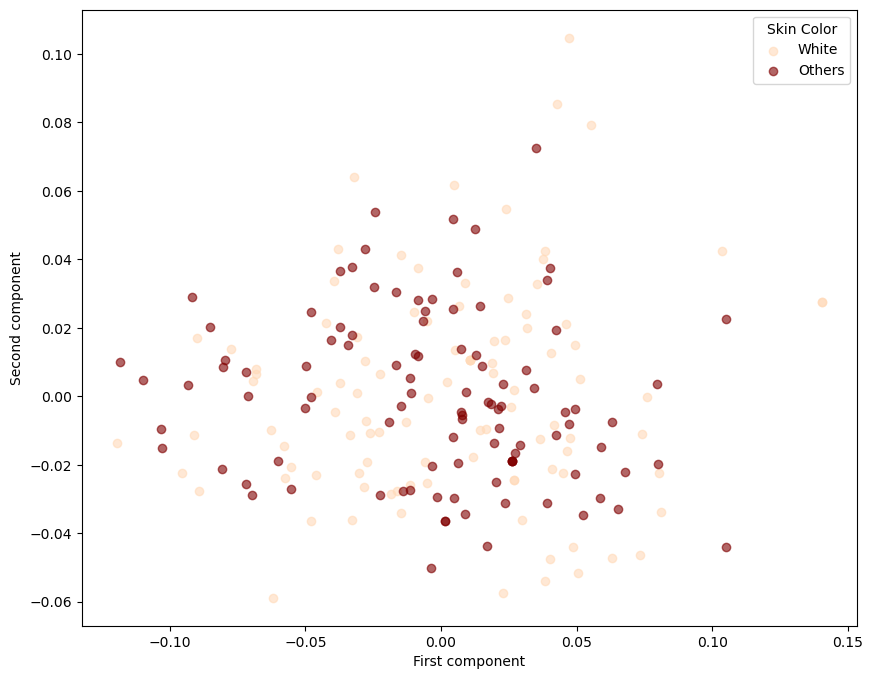

In [64]:
matched_df_pca = PCA(n_components=2).fit(matched_df[['Positive_rate','Negative_rate','neutral_rate']]).transform(matched_df[['Positive_rate','Negative_rate','neutral_rate']])
matched_df_pca = pd.DataFrame(matched_df_pca, columns=['first_component', 'second_component'])
matched_df.index = matched_df_pca.index
matched_df.loc[:, 'first_component'] = matched_df_pca['first_component']
matched_df.loc[:, 'second_component'] = matched_df_pca['second_component']

custom_colors = {'White': 'peachpuff', 'Others': 'maroon'}

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a custom color to each 'Skin Color' category
for skin_color in custom_colors:
    subset = matched_df[matched_df['Skin Color'] == skin_color]
    ax.scatter(subset['first_component'], subset['second_component'], 
               label=skin_color, c=custom_colors[skin_color], alpha=0.6)

# Set the axis labels
ax.set_xlabel("First component")
ax.set_ylabel("Second component")

# Add a legend
ax.legend(title='Skin Color')

# Show the plot
plt.show()

In [65]:
matched_df[['Skin Color', 'Positive_rate', 'Negative_rate', 'neutral_rate']].groupby(by = ['Skin Color']).describe()

Positive_rate                                                    \
                   count      mean       std    min     25%    50%     75%   
Skin Color                                                                   
Others             103.0  0.093854  0.022310  0.048  0.0785  0.094  0.1090   
White              103.0  0.096573  0.030389  0.030  0.0755  0.094  0.1135   

                  Negative_rate            ...                neutral_rate  \
              max         count      mean  ...     75%    max        count   
Skin Color                                 ...                               
Others      0.161         103.0  0.074942  ...  0.1005  0.154        103.0   
White       0.189         103.0  0.076796  ...  0.0915  0.141        103.0   

                                                                    
                mean       std    min     25%    50%    75%    max  
Skin Color                                                          
Others      0.831282  0.038194  0.742  0.8090  0.825  0.851  0.925  
White       0.826709  0.040150  0.713  0.7985  0.821  0.854  0.927  

[2 rows x 24 columns]

let use a t-test to see if the null hypothesis that the average of White is greater or lower is significant.

In [66]:
stats.ttest_ind(matched_df.loc[matched_df['Skin Color'] == 'White']['neutral_rate'], matched_df.loc[matched_df['Skin Color'] == 'Others']['neutral_rate'] )

TtestResult(statistic=-0.8374806812654297, pvalue=0.40330250188115346, df=204.0)

pvalue > 0.05 for the neutral rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [67]:
stats.ttest_ind(matched_df.loc[matched_df['Skin Color'] == 'White']['Positive_rate'], matched_df.loc[matched_df['Skin Color'] == 'Others']['Positive_rate'] )

TtestResult(statistic=0.7318286269385977, pvalue=0.46511304582392554, df=204.0)

pvalue > 0.05 for the positive rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

In [68]:
stats.ttest_ind(matched_df.loc[matched_df['Skin Color'] == 'White']['Negative_rate'], matched_df.loc[matched_df['Skin Color'] == 'Others']['Negative_rate'] )

TtestResult(statistic=0.4573943986533421, pvalue=0.6478743266283186, df=204.0)

pvalue > 0.05 for the negative rate, indicating we can not conlude there is a significant difference between articles categorized as 'white' and 'others' on average

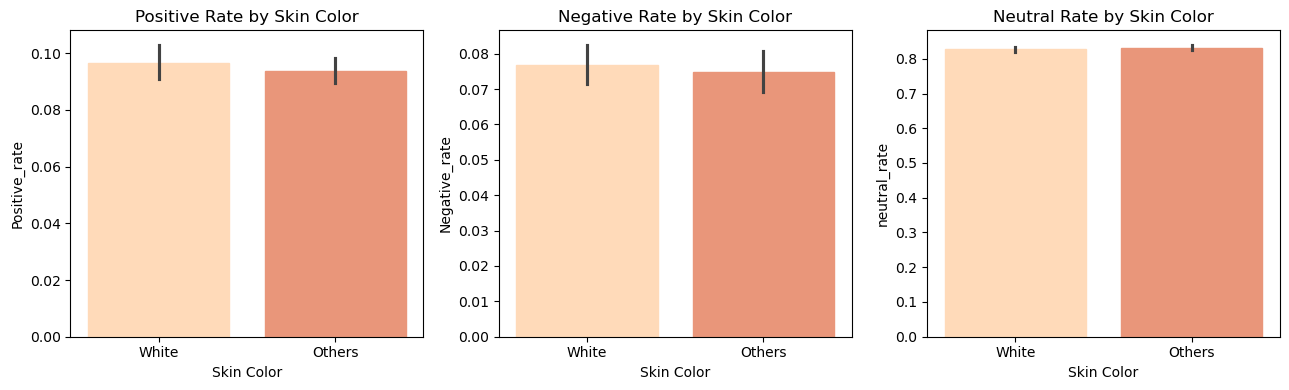

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# First bar plot for Positive_rate
ax1 = sns.barplot(x="Skin Color", y="Positive_rate", data=matched_df, ax=axes[0])
ax1.set_title("Positive Rate by Skin Color")
for bar, skin_color in zip(ax1.patches, matched_df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Second bar plot for Negative_rate
ax2 = sns.barplot(x="Skin Color", y="Negative_rate", data=matched_df, ax=axes[1])
ax2.set_title("Negative Rate by Skin Color")
for bar, skin_color in zip(ax2.patches, matched_df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Third bar plot for Neutral_rate
ax3 = sns.barplot(x="Skin Color", y="neutral_rate", data=matched_df, ax=axes[2])
ax3.set_title("Neutral Rate by Skin Color")
for bar, skin_color in zip(ax3.patches, matched_df["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

plt.tight_layout()
plt.show()

After performing the matching, it becomes clear that we can no longer claim that, on average, Wikispeedia pages featuring 'White' individuals are more negative than those featuring 'Others.' Conclusion: There is no statistically significant difference

Attempt the same analysis using an alternative Sentiment Analyzer. Because Vader was trained and is normally used for social networks. We will employ a more adaptable NLP model named BERT

In [72]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [73]:
corpus_of_matched_people = matched_df['People'].apply(lambda x : plainTextFolder+x+'.txt')

For BERT, we utilize our mapping, and in addition, we will only consider the first 1024 characters of each article. This portion typically corresponds to the initial description or summary of a Wikipedia article, which is the most frequently read by Wikipedia users.

In [74]:
results = list()
for i in range(103):
    with  open(corpus_of_matched_people.iloc[i]) as page:
        page_token = tokenizer.encode(page.read()[0:1024], padding=True, truncation= True, max_length=512, return_tensors='pt')
        result = model(page_token)
        results.append(result.logits)

BERT produces a tensor that provides the probability of the article being rated as 1 star, 2 stars, ..., up to 5 stars.

In [75]:
data = [tensor.flatten().tolist() for tensor in results]
bert_df = pd.DataFrame(data, columns=['one_star', 'two_star','three_star','four_star','five_star'])
bert_df.head(5)

,one_star,two_star,three_star,four_star,five_star
0,-0.152941,-0.127286,0.192592,0.370700,-0.060203
1,0.425771,0.194180,0.147253,0.045961,-0.565788
2,0.443068,-0.042277,0.185532,-0.071184,-0.300782
3,0.422728,0.111796,0.293913,-0.042682,-0.555804
4,0.051113,-0.100539,0.343199,0.155069,-0.208542


To represent the data, we will reduce the dimensionality to two using the PCA algorithm, allowing us to visualize them in two dimensions"

In [76]:
bert_reduced_pca = PCA(n_components=2).fit(bert_df).transform(bert_df)
bert_reduced_pca = pd.DataFrame(bert_reduced_pca, columns=['first_component', 'second_component'])

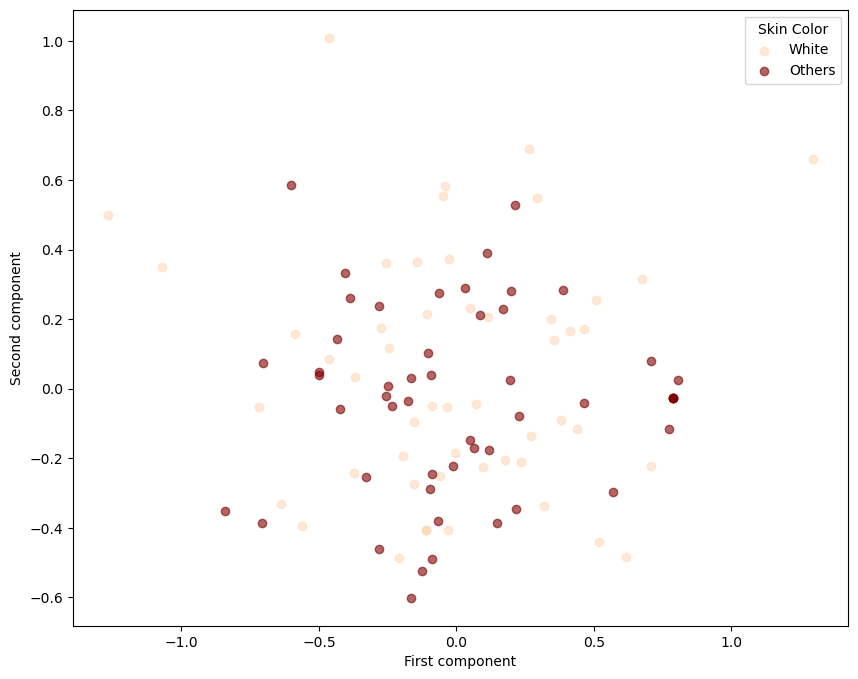

In [77]:
custom_colors = {'White': 'peachpuff', 'Others': 'maroon'}

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a custom color to each 'Skin Color' category
i = 0
for skin_color in custom_colors:
    subset = bert_reduced_pca[bert_reduced_pca.index %2 == i]
    i +=1
    ax.scatter(subset['first_component'], subset['second_component'], 
               label=skin_color, c=custom_colors[skin_color], alpha=0.6)

# Set the axis labels
ax.set_xlabel("First component")
ax.set_ylabel("Second component")

# Add a legend
ax.legend(title='Skin Color')

# Show the plot
plt.show()

We can observe that the data is still evenly distributed. However, let's conduct a statistical analysis to confirm

In [78]:
temp = list()
for i in range(len(bert_reduced_pca)):
    if (i%2==0):
        temp.append('White')
    else : 
        temp.append('Others')

bert_df['Skin_Color'] = temp
bert_reduced_pca['Skin Color'] = temp
bert_reduced_pca.head(5)

,first_component,second_component,Skin Color
0,0.379871,-0.090009,White
1,-0.501516,0.038881,Others
2,-0.374266,-0.241325,White
3,-0.501385,0.048968,Others
4,0.072571,-0.043126,White


In [79]:
stats.ttest_ind(bert_reduced_pca.loc[bert_reduced_pca.index %2 ==0]['first_component'], bert_reduced_pca.loc[bert_reduced_pca.index %2 == 1]['first_component'])

TtestResult(statistic=-0.1351006323415141, pvalue=0.8928011891778199, df=101.0)

In [80]:
stats.ttest_ind(bert_reduced_pca.loc[bert_reduced_pca.index %2 ==0]['second_component'], bert_reduced_pca.loc[bert_reduced_pca.index %2 == 1]['second_component'])

TtestResult(statistic=1.0716130318727473, pvalue=0.28644785962980107, df=101.0)

As we can see, the p-values are still very high, indicating that we cannot draw any conclusion regarding a connection between sentiment analysis and whether an article pertains to white or black

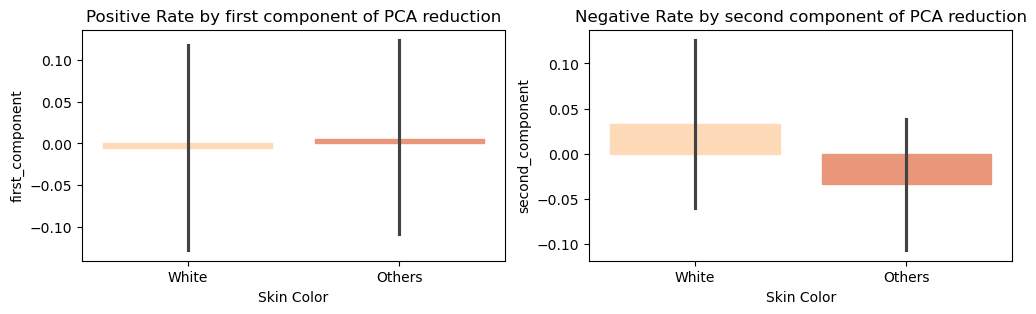

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# First bar plot for Positive_rate
ax1 = sns.barplot(x="Skin Color", y="first_component", data=bert_reduced_pca, ax=axes[0])
ax1.set_title("Positive Rate by first component of PCA reduction")
for bar, skin_color in zip(ax1.patches, bert_reduced_pca["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

# Second bar plot for Negative_rate
ax2 = sns.barplot(x="Skin Color", y="second_component", data=bert_reduced_pca, ax=axes[1])
ax2.set_title("Negative Rate by second component of PCA reduction")
for bar, skin_color in zip(ax2.patches, bert_reduced_pca["Skin Color"]):
    if skin_color == "Others":
        bar.set_color('darksalmon')
    elif skin_color == "White":
        bar.set_color('peachpuff')

So the sentiment of the pages seems to not be the origin of the difference in Victory and Defeat while targeting people. Another reason, could be the distribution of links leading to the article. Indeed, articles don't contain the same amount of link and this wasn't take into account into the previous analysis. So we will explore this possibility.

#### **5.2 LINKS ANALYSIS:**

Lets now dive into a link simple analysis by just checking how many links brings you to people belonging to a given ethnic group. As we want to target people, we want to know how many times the link of each people appears in another page. More different page containing People article links mean more chance to get to the target article.   
An unequal distribution of the number of link toward a page could be at the origin of the bias.

In [82]:
#Creating a dataframe of links where the target link is in People category
linksDf = linksDf.rename(columns = {'Elements' : 'Source', 'links':'People'})
filtered_links = linksDf[linksDf['People'].isin(people_name)] 

In [83]:
#For each people counting how many links goes toward them
link_in = filtered_links.groupby('People').size().reset_index(name='Count')
link_in = pd.merge(link_in, people_color, on = 'People', how='inner'  )
link_in['Skin Color'] = link_in['Skin Color'].where(link_in['Skin Color'] == 'White', 'Others')
link_in = link_in.rename(columns={'Count' : 'Links in' , 2 : 'Category'})
link_in 

,People,Links in,Skin Color,Category
0,Abel_Tasman,5,White,Geographers_and_explorers
1,Abraham_Lincoln,62,White,USA_Presidents
2,Adam_Smith,38,White,Historical_figures
3,Adolf_Hitler,109,White,Political_People
4,Agamemnon,9,White,Historical_figures
...,...,...,...,...
637,Zachary_Taylor,14,White,Political_People
638,Zhang_Qian,3,Others,Historical_figures
639,Zheng_He,8,Others,Historical_figures
640,Ziad_Jarrah,1,Others,Historical_figures


/var/folders/y7/jy5_7zhn0zj995826c8zbsfc0000gp/T/ipykernel_12989/482244081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=link_in, x='Skin Color', y='Links in', palette={'White': 'peachpuff', 'Others': 'darksalmon'})


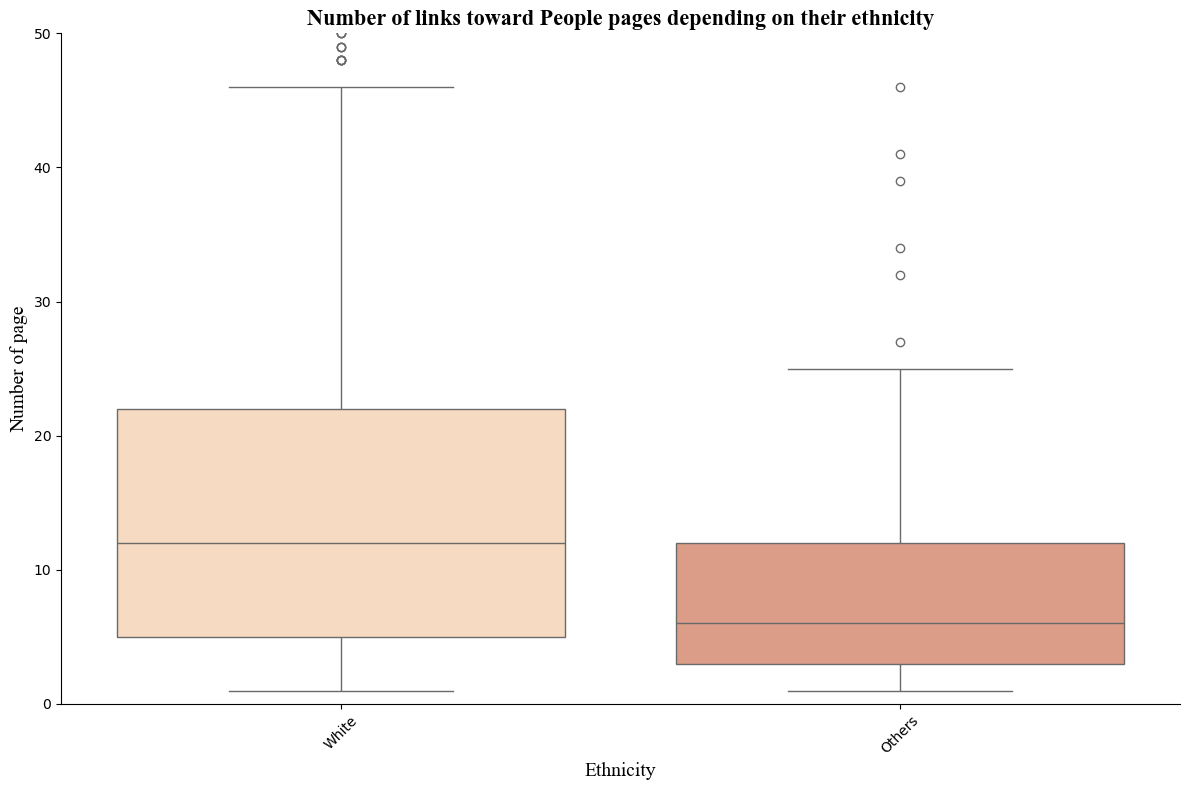

In [84]:
#Vizualise the data
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=link_in, x='Skin Color', y='Links in', palette={'White': 'peachpuff', 'Others': 'darksalmon'})

# Ajouter des titres et libellés
plt.title('Number of links toward People pages depending on their ethnicity',fontname='Times New Roman', fontweight='bold', loc ='center', fontsize=16)
plt.xlabel('Ethnicity', fontname='Times New Roman', fontsize=14)
plt.ylabel('Number of page', fontname='Times New Roman', fontsize=14)
plt.xticks(rotation=45)  # Rotation des libellés de l'axe x pour une meilleure lisibilité
plt.ylim([0, 50])
plt.grid(False)
sns.despine()

# Afficher le graphique
plt.tight_layout()
plt.show()


On average, there is a little more pages containing links toward white people article than towards others ethnics groups. Thus, it should be easier to go toward white people pages but we find out in the causal analysis that it was easier to win while the target was in others ethnics groups. 

### **6. Conclusion**


To conclude, surprisingly it seems easier to win when the person targeted belongs to 'other ethnicities'. The origin of this bias does not seem to be due to Wikispeedia but more to general knowledge. Indeed, sentiment analysis shows no difference in the way pages are written, and the distribution of links leans towards inequality in favor of white people. 
Although the bias in the victory is in favor of other ethnicities, there is still an inequality in the representation of other ethnicities people within the game and in the number of links to access these pages. Moreover, the causal analysis should be considered carefully, as only one matching was made based on the propensity score. Some confounders are difficult to determine due to a lack of data, such as player level.
So, if MJ wants to be seen more, it would seem that being affiliated with the 'white' ethnicity is the best choice. However, if he aims to help the player win, he should choose to belong to another ethnicity.

